# Fit Fourier series to velocity time series

In [1]:
import rioxarray as rxr
import numpy as np
import scipy
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy
import os
import xarray as xr
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler

## Load velocity datacube

In [5]:
#data_path = '/Users/raineyaberle/Research/PhD/Hubbard/'
data_path = '/Users/amyjenson/Documents/GitHub/Hubbard2024/make_paper_figures/'

xds = rxr.open_rasterio(os.path.join(data_path, 'data', 
                                     'Hubbard_S1.nc'))
# Add velocity magnitude variable
xds['v'] = np.sqrt(xds['vx']**2 + xds['vy']**2)

/Users/amyjenson/miniconda3/envs/pseudo_base/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/amyjenson/miniconda3/envs/pseudo_base/lib/python3.12/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/Users/amyjenson/miniconda3/envs/pseudo_base/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/amyjenson/miniconda3/envs/pseudo_base/lib/python3.12/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform

## Clip to glacier boundaries

In [7]:
bounds = gpd.read_file(os.path.join(data_path, 'RGI', 'Hubbard_boundaries_clipped.shp'))
xds_clip = xds.rio.clip(bounds.geometry.values, bounds.crs)
# Remove wonky values
xds_clip = xr.where(xds_clip < 10e3, xds_clip, np.nan)

DriverError: /Users/amyjenson/Documents/GitHub/Hubbard2024/make_paper_figures/RGI/Hubbard_boundaries_clipped.shp: No such file or directory

In [6]:
# Plot the spatial mean over time for a point near the terminus
v_mean = xds_clip['v'].mean(dim=['x', 'y']).data
t = np.array([np.datetime64(x) for x in xds_clip.time.data]).astype('datetime64[D]')
dt = (t - t[0]).astype(float)
plt.plot(t, v_mean)
# plt.ylim(0,2e3)
plt.xlabel('Date')
plt.ylabel('Velocity [m/y]')
# plt.xlim(np.datetime64('2018-01-01'), np.datetime64('2023-01-01'))
# plt.ylim(0,5e3)
plt.show()

NameError: name 'xds_clip' is not defined

In [219]:
def fourier_model(c, x, y):
    """
    Generate a Fourier series model from coefficients.
    
    Parameters:
        c: int
            Number of coefficients.
        x: np.array
            x-values to evaluate the model at.
        y: np.array
            True labels for the data.
            
    Returns:
        ymod: np.array
            Modeled y-values.
    """
    n = c // 2
    
    if n == 3:  
        def ymod(x, a0, a1, b1, a2, b2, a3, b3, w):
            return a0 + a1 * np.cos(x * w) + b1 * np.sin(x * w) + \
                   a2 * np.cos(2 * x * w) + b2 * np.sin(2 * x * w) + \
                   a3 * np.cos(3 * x * w) + b3 * np.sin(3 * x * w)
    elif n == 4:  
        def ymod(x, a0, a1, b1, a2, b2, a3, b3, a4, b4, w):
            return a0 + a1 * np.cos(x * w) + b1 * np.sin(x * w) + \
                   a2 * np.cos(2 * x * w) + b2 * np.sin(2 * x * w) + \
                   a3 * np.cos(3 * x * w) + b3 * np.sin(3 * x * w) + \
                   a4 * np.cos(4 * x * w) + b4 * np.sin(4 * x * w)
    elif n == 5:  
        def ymod(x, a0, a1, b1, a2, b2, a3, b3, a4, b4, a55, b5, w):
            return a0 + a1 * np.cos(x * w) + b1 * np.sin(x * w) + \
                   a2 * np.cos(2 * x * w) + b2 * np.sin(2 * x * w) + \
                   a3 * np.cos(3 * x * w) + b3 * np.sin(3 * x * w) + \
                   a4 * np.cos(4 * x * w) + b4 * np.sin(4 * x * w) + \
                   a5 * np.cos(4 * x * w) + b5 * np.sin(4 * x * w)
    elif n == 6:  
        def ymod(x, a0, a1, b1, a2, b2, a3, b3, a4, b4, a5, b5, a6, b6, w):
            return a0 + a1 * np.cos(x * w) + b1 * np.sin(x * w) + \
                   a2 * np.cos(2 * x * w) + b2 * np.sin(2 * x * w) + \
                   a3 * np.cos(3 * x * w) + b3 * np.sin(3 * x * w) + \
                   a4 * np.cos(4 * x * w) + b4 * np.sin(4 * x * w) + \
                   a5 * np.cos(4 * x * w) + b5 * np.sin(4 * x * w) + \
                   a6 * np.cos(4 * x * w) + b6 * np.sin(4 * x * w)
            
    elif n == 7:  # 4 terms
        def ymod(x, a0, a1, b1, a2, b2, a3, b3, a4, b4, a5, b5, a6, b6, a7, b7, w):
            return a0 + a1 * np.cos(x * w) + b1 * np.sin(x * w) + \
                   a2 * np.cos(2 * x * w) + b2 * np.sin(2 * x * w) + \
                   a3 * np.cos(3 * x * w) + b3 * np.sin(3 * x * w) + \
                   a4 * np.cos(4 * x * w) + b4 * np.sin(4 * x * w) + \
                   a5 * np.cos(5 * x * w) + b5 * np.sin(5 * x * w) + \
                   a6 * np.cos(6 * x * w) + b6 * np.sin(6 * x * w) + \
                   a7 * np.cos(7 * x * w) + b7 * np.sin(7 * x * w) 
    elif n == 8:  # 4 terms
        def ymod(x, a0, a1, b1, a2, b2, a3, b3, a4, b4, a5, b5, a6, b6, a7, b7, a8, b8, w):
            return a0 + a1 * np.cos(x * w) + b1 * np.sin(x * w) + \
                   a2 * np.cos(2 * x * w) + b2 * np.sin(2 * x * w) + \
                   a3 * np.cos(3 * x * w) + b3 * np.sin(3 * x * w) + \
                   a4 * np.cos(4 * x * w) + b4 * np.sin(4 * x * w) + \
                   a5 * np.cos(5 * x * w) + b5 * np.sin(5 * x * w) + \
                   a6 * np.cos(6 * x * w) + b6 * np.sin(6 * x * w) + \
                   a7 * np.cos(7 * x * w) + b7 * np.sin(7 * x * w) + \
                   a8 * np.cos(8 * x * w) + b8 * np.sin(8 * x * w)
    elif n == 9:  # 4 terms
        def ymod(x, a0, a1, b1, a2, b2, a3, b3, a4, b4, a5, b5, a6, b6, a7, b7, a8, b8, a9, b9, w):
            return a0 + a1 * np.cos(x * w) + b1 * np.sin(x * w) + \
                   a2 * np.cos(2 * x * w) + b2 * np.sin(2 * x * w) + \
                   a3 * np.cos(3 * x * w) + b3 * np.sin(3 * x * w) + \
                   a4 * np.cos(4 * x * w) + b4 * np.sin(4 * x * w) + \
                   a5 * np.cos(5 * x * w) + b5 * np.sin(5 * x * w) + \
                   a6 * np.cos(6 * x * w) + b6 * np.sin(6 * x * w) + \
                   a7 * np.cos(7 * x * w) + b7 * np.sin(7 * x * w) + \
                   a8 * np.cos(8 * x * w) + b8 * np.sin(8 * x * w) + \
                   a9 * np.cos(9 * x * w) + b9 * np.sin(9 * x * w)
    elif n == 10:  # 4 terms
        def ymod(x, a0, a1, b1, a2, b2, a3, b3, a4, b4, a5, b5, a6, b6, a7, b7, a8, b8, a9, b9, a10, b10, w):
            return a0 + a1 * np.cos(x * w) + b1 * np.sin(x * w) + \
                   a2 * np.cos(2 * x * w) + b2 * np.sin(2 * x * w) + \
                   a3 * np.cos(3 * x * w) + b3 * np.sin(3 * x * w) + \
                   a4 * np.cos(4 * x * w) + b4 * np.sin(4 * x * w) + \
                   a5 * np.cos(5 * x * w) + b5 * np.sin(5 * x * w) + \
                   a6 * np.cos(6 * x * w) + b6 * np.sin(6 * x * w) + \
                   a7 * np.cos(7 * x * w) + b7 * np.sin(7 * x * w) + \
                   a8 * np.cos(8 * x * w) + b8 * np.sin(8 * x * w) + \
                   a9 * np.cos(9 * x * w) + b9 * np.sin(9 * x * w) + \
                   a10 * np.cos(10 * x * w) + b10 * np.sin(10 * x * w)
    # Optimize the model
    params, _ = curve_fit(ymod, x, y)
    
    return ymod, params

def model_error(model, X_test, y_test, params):
    """
    Calculate error of the model.
    
    Parameters:
        model: callable
            Fitted model function.
        X_test: np.array
            Test data.
        y_test: np.array
            True labels for the test data.
            
    Returns:
        error: float
            Root Mean Squared Error (RMSE) of the model.
    """
    y_pred = model(X_test, *params)
    error = np.sqrt(np.mean((y_test - y_pred)**2))
    return error

def fit_fourier_MC(t, V, nMC=100, pTrain=0.8):
    """
    Fit Fourier series to the data using Monte Carlo simulations to find the ideal number of terms.
    
    Parameters:
        t: np.array
            Time variable for model fitting.
        V: np.array
            Input data for fitting the Fourier series.
        nMC: int
            Number of Monte Carlo simulations.
        pTrain: float, optional (default=0.8)
            Proportion of data to use for training.
            
    Returns:
        best_model: callable
            Fitted model with the ideal number of terms.
        best_error: float
            Root Mean Squared Error (RMSE) of the best model.
    """
    # Convert time variable to days since first day for model fitting
    t = np.array([np.datetime64(x) for x in t]).astype('datetime64[D]')
    days = (t - t[0]).astype(float)
    years = np.unique(t.astype('datetime64[Y]'))
    n_years = len(years)  # Number of years for estimating number of terms
    
    # Initialize parameters
    terms = np.zeros(nMC, dtype=int)  # Number of terms for the best fit model
    error = np.zeros(nMC)  # Error associated with the best fit model
    
    print('Conducting Monte Carlo simulations to find ideal number of terms')
    for c in range(nMC):
        # Split data into training and testing
        X_train, X_test, y_train, y_test = train_test_split(days, V, test_size=1 - pTrain, random_state=42)
        
        # Try Fourier fits with 3 different numbers of terms to tpos data
        fouriern_1, fouriern, fouriern_plus1 = n_years-1, n_years, n_years+1
        
        # Fit Fourier curves to the training data
        fn_1, fn_1_params = fourier_model(2 * fouriern_1 + 2, X_train, y_train)
        fn, fn_params = fourier_model(2 * fouriern + 2, X_train, y_train)
        fn_plus1, fn_plus1_params = fourier_model(2 * fouriern_plus1 + 2, X_train, y_train)
        
        # Calculate errors for each model
        error_fn_1 = model_error(fn_1, X_test, y_test, fn_1_params)
        error_fn = model_error(fn, X_test, y_test, fn_params)
        error_fn_plus1 = model_error(fn_plus1, X_test, y_test, fn_plus1_params)
        
        # Identify the Fourier model with the lowest error (modal choice)
        min_error, idx = min((val, idx) for (idx, val) in enumerate([error_fn_1, error_fn, error_fn_plus1]))
        if idx == 0:
            best_model = fn_1
            terms[c] = fouriern_1
            error[c] = min_error
        elif idx == 1:
            best_model = fn
            terms[c] = fouriern
            error[c] = min_error
        elif idx == 2:
            best_model = fn_plus1
            terms[c] = fouriern_plus1
            error[c] = min_error
            
    print('MC done.')
    
    # Select the model with the lowest average error over the Monte Carlo iterations
    avg_error = np.mean(error)
    best_idx = np.argmin(error)
    print('Optimal number of terms = ', terms[best_idx])
    best_model, best_params = fourier_model(2 * terms[best_idx] + 2, days, V)
    best_error = error[best_idx]

    # Plot results
    fig, ax = plt.subplots()
    ax.plot(t, V, label='y')
    ax.plot(t, best_model(days, *best_params), label='y$_{mod}$')
    ax.set_title(f'Best model error = {best_error}')
    ax.legend(loc='best')
    ax.grid()
    plt.show()
  
    return best_model, best_params, best_error


Conducting Monte Carlo simulations to find ideal number of terms
MC done.
Optimal number of terms =  7


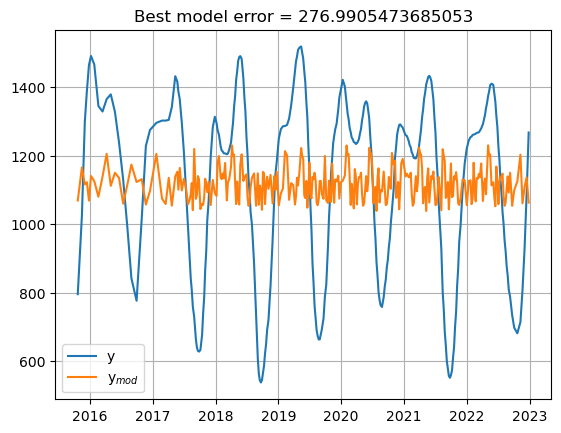

In [220]:
x = xds.time.data
y = v_mean

best_model, best_params, best_error = fit_fourier_MC(x, y)

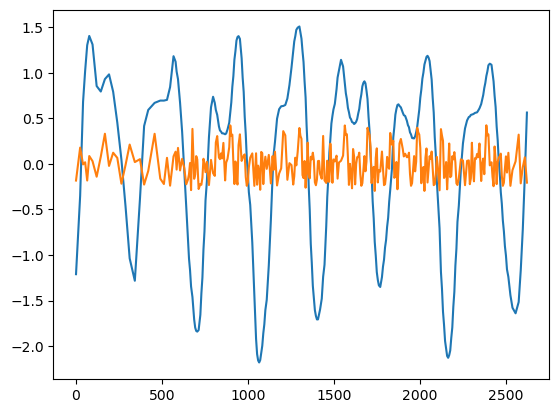

In [261]:
def ymod(x, a0, a1, b1, a2, b2, a3, b3, a4, b4, a5, b5, a6, b6, a7, b7, a8, b8, w):
    return a0 + a1 * np.cos(x * w) + b1 * np.sin(x * w) + \
           a2 * np.cos(2 * x * w) + b2 * np.sin(2 * x * w) + \
           a3 * np.cos(3 * x * w) + b3 * np.sin(3 * x * w) + \
           a4 * np.cos(4 * x * w) + b4 * np.sin(4 * x * w) + \
           a5 * np.cos(5 * x * w) + b5 * np.sin(5 * x * w) + \
           a6 * np.cos(6 * x * w) + b6 * np.sin(6 * x * w) + \
           a7 * np.cos(7 * x * w) + b7 * np.sin(7 * x * w) + \
           a8 * np.cos(8 * x * w) + b8 * np.sin(8 * x * w)

# Optimize the model
y_scaled = StandardScaler().fit_transform(y.reshape(-1,1)).flatten()
t = np.array([np.datetime64(xx) for xx in x]).astype('datetime64[D]')
dt = (t-t[0]).astype(float)
params, _ = curve_fit(ymod, days, y_scaled)

# Plot
ypred = ymod(days, *params)
plt.plot(days, y_scaled)
plt.plot(days, ypred)
plt.show()